# SEMITONES application - Granja et al.

In [15]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
import seaborn as sns
from random import shuffle
from SEMITONES.support_funcs import pairwise_similarities
from sklearn.metrics.pairwise import pairwise_kernels
from SEMITONES.enrichment_scoring import permute
from SEMITONES.enrichment_scoring import sig_interval
from SEMITONES.support_funcs import sig_dictionary
from SEMITONES.support_funcs import sig_bool
from SEMITONES.cell_selection import from_knn_dist

In [4]:
adata = ad.read_h5ad("../raw/scATAC-Healthy-Hematopoiesis-191120-adata")
umap2 = np.genfromtxt('../processed/Granja_ATAC_umap2.csv', delimiter=',')
umap25 = np.genfromtxt('../processed/Granja_ATAC_umap25.csv', delimiter=',')

In [6]:
# determine gamma, select the gamma value that the most cell types are covered by at least one reference cell
def n_rcell(g):
    
    S = pairwise_kernels(umap25, metric='rbf',gamma=g)
    median = np.median(S, axis=0)
    start = int(np.argmin(median))

    dd_rcells = from_knn_dist(X=umap25,
                             n_ret=100,
                             start=start,
                             metric='rbf',
                             metric_params={"gamma": g})
    r_cell_type=adata.obs['BioClassification'][dd_rcells]
    res = r_cell_type.unique().shape[0]
    return res

nl = []
gl = []
# because this step is time consuming, we took a smaller range of gamma as example
for g in np.arange(0.4,0.6,0.01):
    nl.append(n_rcell(g))
    gl.append(g)

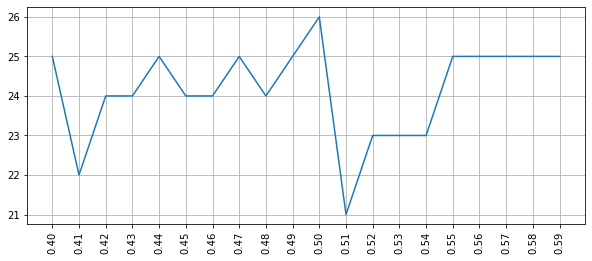

In [8]:
plt.figure(figsize=(10,4))
plt.plot(gl,nl)
plt.xticks(np.arange(0.4,0.6,0.01), rotation=90)
plt.grid()
plt.show()

In [9]:
# check the selected reference cells
g=0.5

S = pairwise_kernels(umap25, metric='rbf',gamma=g)
median = np.median(S, axis=0)
start = int(np.argmin(median))

dd_rcells = from_knn_dist(X=umap25,
                         n_ret=100,
                         start=start,
                         metric='rbf',
                         metric_params={"gamma": g})

In [10]:
r_cell_type=adata.obs['BioClassification'][dd_rcells]
r_cell_type.value_counts()

12_CD14.Mono.2    11
22_CD4.M           8
05_CMP.LMPP        7
01_HSC             6
24_CD8.CM          6
17_B               6
07_GMP             5
20_CD4.N1          5
11_CD14.Mono.1     5
02_Early.Eryth     4
21_CD4.N2          4
08_GMP.Neut        4
15_CLP.2           3
25_NK              3
23_CD8.EM          3
09_pDC             3
06_CLP.1           3
04_Early.Baso      2
16_Pre.B           2
10_cDC             2
19_CD8.N           2
13_Unk             2
14_Unk             1
18_Plasma          1
03_Late.Eryth      1
26_Unk             1
Name: BioClassification, dtype: int64

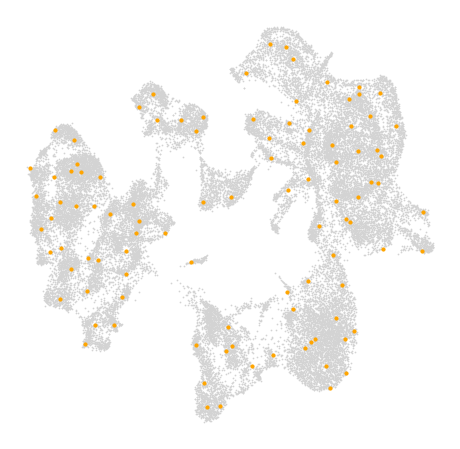

In [11]:
plt.figure(figsize=(8,8))
plt.scatter(umap2[:,0],umap2[:,1],s=0.5,c='lightgrey')
plt.scatter(umap2[dd_rcells, 0], umap2[dd_rcells, 1], s=10, c='orange')
plt.axis('off')
plt.show()

Run Granja_scores.py to calculate SEMITONES enrichment scores and permutation scores.

In [12]:
escores = pd.read_hdf('../processed/Granja_ATAC_escore.h5', 'escores')
pscores = pd.read_hdf('../processed/Granja_ATAC_pscore.h5', 'pscores')

In [13]:
# determine the significantly enriched features
interval = sig_interval(pscores, n_sds=10)
sigdict_acc = sig_dictionary(escores, interval, sign='positive')
sigdict_inacc = sig_dictionary(escores, interval, sign='negative')
sigdict = sig_dictionary(escores, interval)

In [14]:
# load Homer annotation
ann = pd.read_csv('../processed/Granja_ATAC_anno.txt', sep='\t', index_col=0)
indexdf = adata.var.set_index('name')
ann = ann.reindex(indexdf.index)

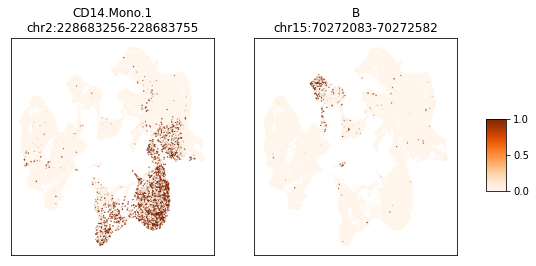

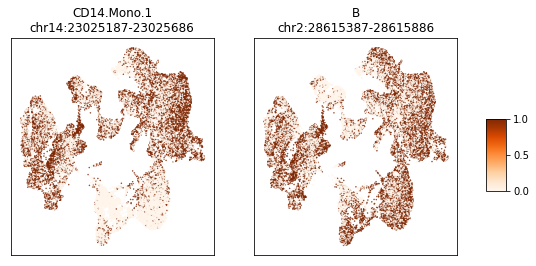

In [16]:
# examples of selectively accessible regions and selectively inaccessible regions identified by SEMITONES
names = ann['Chr']+':'+ann['Start'].astype(str)+'-'+ann['End'].astype(str)

def top_one_plots(rcells_list, acc='acc'):
    fig, axs = plt.subplots(1,len(rcells_list), figsize=(4*len(rcells_list),4))
    for ax,rcell in zip(axs, rcells_list):
        
        if acc=='acc':
            # selectively acc
            index = escores[rcell].rank(ascending=False).sort_values().index[0]
        else:
            # selectively inacc
            index = escores[rcell].rank(ascending=True).sort_values().index[0]

        ct = adata.obs['BioClassification'][rcell]
        ct = ct.split('_')[1]
        ft = names[index]

        colors = adata.layers['b'][:,index].todense().tolist()
        ax.scatter(umap2[:,0], umap2[:,1], c=colors, cmap='Oranges', s=0.2)
        ax.set_title('{}\n{}'.format(ct, ft))
        ax.set_xticks([])
        ax.set_yticks([])
    sm =  ScalarMappable(norm=plt.Normalize(0, 1), cmap='Oranges')
    sm.set_array([])
    # [left, bottom, width, height]
    cax = plt.axes([0.95, 0.35, 0.035, 0.25])
    cbar = fig.colorbar(sm, ax=axs, cax=cax)
    fig.savefig('../figures/SEMITONES/Granja_{}_umap.png'.format(acc), bbox_inches='tight')
    plt.show()

#rcell = escores.columns[2]
top_one_plots([escores.columns[2], escores.columns[31]], acc='acc')
top_one_plots([escores.columns[2], escores.columns[31]], acc='inacc')